In [1]:
# import modules
import datetime #, timedelta
import time
import json
import pandas as pd
import numpy as np
import decimal
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scienceplots
import matplotlib 

# from plotly.subplots import make_subplots
import plotly.graph_objects as go

import boto3
from boto3.dynamodb.conditions import Key, Attr

# Obtain secret key for AWS
f = open("secret.txt")
text = f.readlines()

# Access dynamodb on AWS
dynamodb = boto3.resource(
    "dynamodb",
    aws_access_key_id=text[0][:-1],
    aws_secret_access_key=text[1][:-1],
    region_name="us-east-2",
)

    
plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['axes.linewidth'] = 1
# plt.rcParams['figure.dpi'] =300

w = 3.3 
h = 2.5

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]

In [2]:
!pip freeze > requirements.txt

In [2]:
# Scan through all Sessions2 data to get session items
table = dynamodb.Table('Sessions2')
params = {'ProjectionExpression': "dcosId,userId,user_email,vehicle_model,vehicle_maxChgRate_W,siteId,stationId,connectTime,startChargeTime,Deadline,energyReq_Wh,estCost,reg_centsPerHr,sch_centsPerHr,sch_centsPerKwh,sch_centsPerOverstayHr,#Dur,DurationHrs,choice,regular,scheduled,cumEnergy_Wh,peakPower_W,power,lastUpdate",
          'ExpressionAttributeNames': {"#Dur":"Duration"}}

# Repeat scan until LastEvaluatedKey is None
start = time.time()
done = False
start_key = None
temp = []
while not done:
    if start_key:
        params['ExclusiveStartKey'] = start_key
    response = table.scan(**params)
    temp.extend(response.get('Items', []))
    print("Length of Scanned Items is {0} items".format(len(temp)))
    start_key = response.get('LastEvaluatedKey', None)
    done = start_key is None

# Print elapsed time
end = time.time()
elapsed_time_min = np.floor((end-start)/60)
elapsed_time_sec = (end-start) % 60
elapsed_time = "Elapsed time: %d minutes, %d seconds" % (elapsed_time_min, elapsed_time_sec)
print(elapsed_time)

# Create dataframe
session_df = pd.DataFrame(temp)
del temp


Length of Scanned Items is 723 items
Length of Scanned Items is 1445 items
Length of Scanned Items is 2172 items
Length of Scanned Items is 2886 items
Length of Scanned Items is 3537 items
Elapsed time: 0 minutes, 15 seconds


## Expected Energy Demand, Duration

In [3]:
session_df['connectTime']  = pd.to_datetime(session_df['connectTime'] )
session_df['startChargeTime']  = pd.to_datetime(session_df['startChargeTime'] )
session_df['Deadline']  = pd.to_datetime(session_df['Deadline'] )
session_df['lastUpdate']  = pd.to_datetime(session_df['lastUpdate'])
session_df = session_df.sort_values(by='connectTime')
session_df = session_df[session_df['siteId'] == 25]
session_df['interArrivalTime_min'] = session_df['connectTime'].diff().dt.seconds / 60
plot_df = session_df[session_df['connectTime'].dt.year >= 2022]
session_df['arrHour']=session_df['connectTime'].dt.hour

session_df['cumEnergy_Wh']=session_df['cumEnergy_Wh'].astype(float)
session_df['cumEnergy_KWh']=session_df['cumEnergy_Wh']/1000
session_df['DurationHrs'] = session_df['DurationHrs'].astype(float)

In [4]:
# 1. peakPower_W = 0 and cumEnergy_W = 0: delete  
session_df = session_df[(session_df["peakPower_W"]!=0) & (session_df["cumEnergy_Wh"]!=0)]

# 2. Fix the user peak_powers 
# some users have historical peak power > 6.6 / 7 
user_df = session_df[['userId','peakPower_W','vehicle_maxChgRate_W']].groupby('userId').max()
user_df['session_counts'] = session_df[['userId','peakPower_W']].groupby('userId').count()

validate_users = user_df[(user_df['session_counts']==1) & (user_df['peakPower_W']<=6000) ].index.to_list()
user_df.reset_index(drop=False,inplace=True)

user_df.rename(columns={"peakPower_W":'historical_peakPower_w'},inplace=True)
session_df = session_df.merge(user_df[['userId','historical_peakPower_w']])

In [5]:
optimizer_time = pd.Timestamp(2023, 2, 7, 8)
session_df['endTime'] = session_df['startChargeTime'] + pd.to_timedelta(session_df['Duration'])
cols = ['connectTime','choice','power','endTime','Duration', 'userId', 'Deadline', 'startChargeTime','DurationHrs','dcosId', 'lastUpdate' ]
session_df[(session_df['startChargeTime']>optimizer_time)].sort_values(by='connectTime')[cols]

,connectTime,choice,power,endTime,Duration,userId,Deadline,startChargeTime,DurationHrs,dcosId,lastUpdate
961,2023-02-07 08:32:19,REGULAR,"[{'power_W': 6736, 'timestamp': 1675812017}]",2023-02-07 15:20:17,0 days 06:47:48,792,NaT,2023-02-07 08:32:29,6.79666,4150,2023-02-07 15:20:17
2469,2023-02-07 08:39:32,REGULAR,"[{'power_W': 6682, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 05:03:48,1233,NaT,2023-02-07 08:41:21,5.06333,4151,2023-02-07 13:45:09
1850,2023-02-07 09:02:28,SCHEDULED,"[{'power_W': 4497, 'timestamp': 1675810509}]",2023-02-07 14:55:09,0 days 05:51:44,1126,2023-02-07 15:00:00,2023-02-07 09:03:25,5.86222,4153,2023-02-07 14:55:09
1426,2023-02-07 09:19:18,REGULAR,"[{'power_W': 3576, 'timestamp': 1675806309}]",2023-02-07 13:45:09,0 days 04:24:03,988,NaT,2023-02-07 09:21:06,4.40083,4154,2023-02-07 13:45:09
2057,2023-02-07 09:50:38,REGULAR,"[{'power_W': 6624, 'timestamp': 1675809308}]",2023-02-07 14:35:08,0 days 04:44:16,1149,NaT,2023-02-07 09:50:52,4.73777,4155,2023-02-07 14:35:08
...,...,...,...,...,...,...,...,...,...,...,...
2566,2023-04-17 12:59:03,REGULAR,"[{'power_W': 6666, 'timestamp': 1681761909}, {...",2023-04-17 17:00:10,0 days 04:00:41,1258,NaT,2023-04-17 12:59:29,4.01138,4779,2023-04-17 17:00:10
2274,2023-04-17 13:41:28,REGULAR,"[{'power_W': 6096, 'timestamp': 1681764308}, {...",2023-04-17 18:45:09,0 days 05:01:35,1180,NaT,2023-04-17 13:43:34,5.02638,4780,2023-04-17 18:45:09
2414,2023-04-17 18:25:41,REGULAR,"[{'power_W': 6620, 'timestamp': 1681781411}, {...",2023-04-17 19:30:12,0 days 01:04:24,1205,NaT,2023-04-17 18:25:48,1.07333,4781,2023-04-17 19:30:12
1224,2023-04-17 20:15:35,REGULAR,"[{'power_W': 2471, 'timestamp': 1681788009}, {...",2023-04-17 20:45:08,0 days 00:27:04,911,NaT,2023-04-17 20:18:04,0.45111,4782,2023-04-17 20:45:08


In [6]:
high_power_idx = list(session_df[session_df['historical_peakPower_w'] >= 5000].index)
low_power_idx = list(session_df[session_df['historical_peakPower_w'] < 5000].index)

session_df['highPower'] = pd.Series(dtype=int)

session_df.loc[high_power_idx ,'highPower'] = 1
session_df.loc[low_power_idx ,'highPower'] = 0

session_df.loc[high_power_idx ,'userPower_kW'] = 6.6
session_df.loc[low_power_idx ,'userPower_kW'] = 3.3

In [7]:
plt.rcParams['figure.dpi'] =300

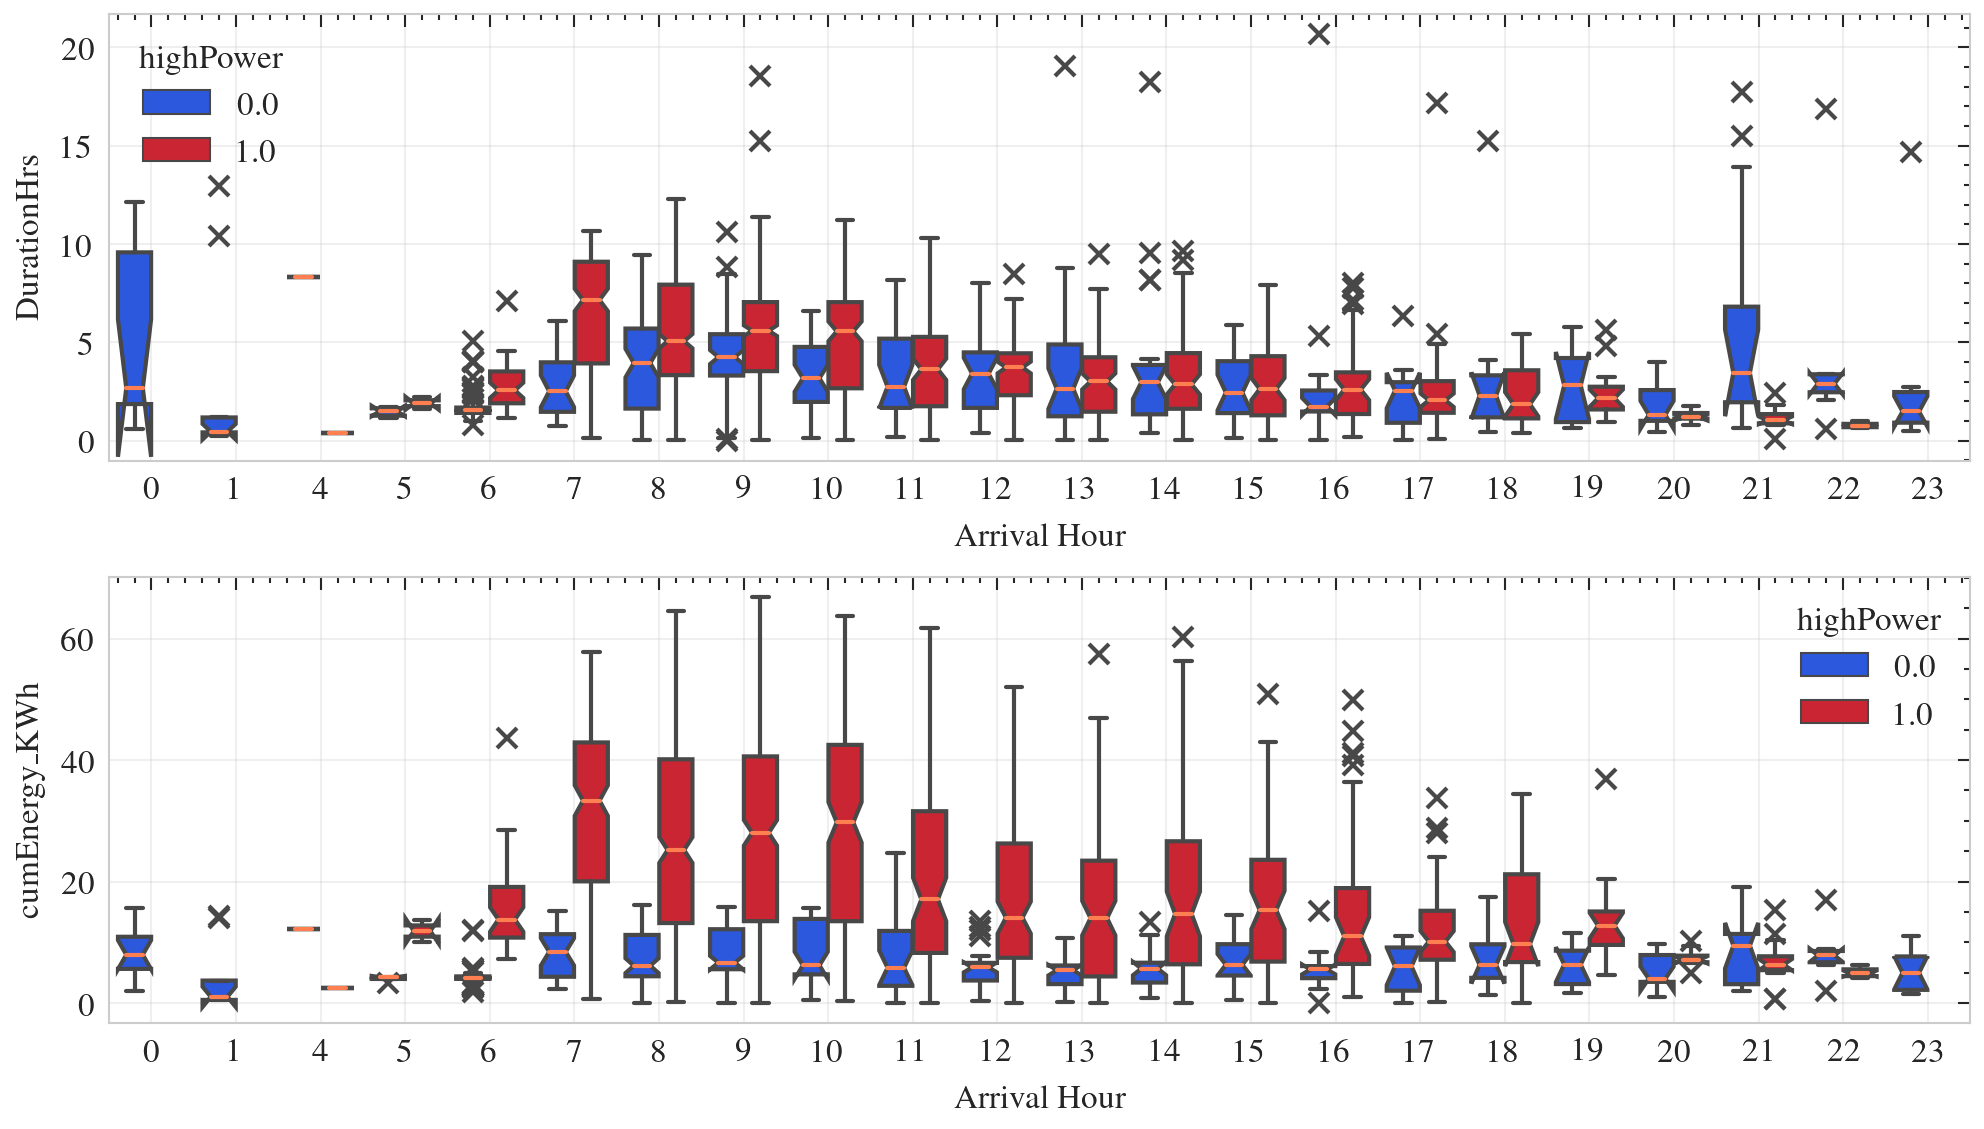

In [8]:
fig,ax= plt.subplots(2,1,figsize=( w*2, h*1.5 ))

sns.boxplot(
    data=session_df, x="arrHour", y="DurationHrs",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[0]
)

sns.boxplot(
    data=session_df, x="arrHour", y="cumEnergy_KWh",hue='highPower',
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    medianprops={"color": "coral"},ax=ax[1]
)

for i in [0,1]:
    ax[i].grid(alpha=0.3)
    ax[i].set_xlabel("Arrival Hour")

In [9]:
iterables = [[0,1], range(0,24)]
idx = pd.MultiIndex.from_product(iterables, names=['highPower','arrHour'])
# pd.DataFrame(index=idx,columns = ['DurationHrs', 'cumEnergy_Wh', 'interArrivalTime_min', 'arrivalHour','cumEnergy_KWh', 'count'])
expected_demand = session_df.groupby(['highPower','arrHour']).mean()
expected_demand['count'] = session_df.groupby(['highPower','arrHour']).count()['dcosId']
expected_demand = expected_demand.reindex(idx).reset_index(drop=False)
expected_demand.rename(columns = {'cumEnergy_Wh':"estEnergyWh", 
                                  'cumEnergy_KWh':"estEnergykWh", 
                                  "DurationHrs":"estDurationHrs"},inplace=True)


expected_demand['count'].fillna(0,inplace=True)
# expected_demand.fillna(method='ffill',inplace=True)

C:\Users\Holiday\AppData\Local\Temp\ipykernel_6888\660894383.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  expected_demand = session_df.groupby(['highPower','arrHour']).mean()


In [10]:
for i in range(0, len(expected_demand), 24):
    group = expected_demand.iloc[i:i+24]
    group.fillna(method='ffill', inplace=True)
    group.fillna(method='bfill', inplace=True)

C:\Users\Holiday\AppData\Local\Temp\ipykernel_6888\4109480676.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.fillna(method='ffill', inplace=True)
C:\Users\Holiday\AppData\Local\Temp\ipykernel_6888\4109480676.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group.fillna(method='bfill', inplace=True)


In [11]:
expected_demand

,highPower,arrHour,estDurationHrs,estEnergyWh,interArrivalTime_min,estEnergykWh,userPower_kW,count
0,0,0,5.115760,8349.500000,533.111111,8.349500,3.3,12.0
1,0,1,3.004533,4106.888889,376.848148,4.106889,3.3,9.0
2,0,2,3.004533,4106.888889,376.848148,4.106889,3.3,0.0
3,0,3,3.004533,4106.888889,376.848148,4.106889,3.3,0.0
4,0,4,8.323880,12213.000000,704.250000,12.213000,3.3,1.0
5,0,5,1.465440,3995.000000,1003.226667,3.995000,3.3,5.0
6,0,6,1.637458,4215.265306,993.837483,4.215265,3.3,245.0
7,0,7,2.707414,8080.625000,659.505556,8.080625,3.3,24.0
8,0,8,3.994458,7478.844156,363.504978,7.478844,3.3,77.0
9,0,9,4.297330,8311.197674,229.927907,8.311198,3.3,86.0


# Test Station Level Optimizer
Currently optimizer works only with the simulator. <br>
Start with the simple case: Run with no-on going sessions. 



In [12]:
import optimizer_station as opt
# We define the timesteps in the APP as 15 minute 
delta_t = 0.25 #hour 
print("For delta_t: ",delta_t, "max number of intervals:",24/delta_t)
################## Define the TOU Cost ##########################################
## the TOU cost is defined considering the delta_t above, if not code raises an error.##

# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh

TOU_tariff[36:56] = 14.9

For delta_t:  0.25 max number of intervals: 96.0


# Optimization with station information

In [16]:
optimizer_time = pd.Timestamp(2023, 4, 6, 7, 0, 0)
print(optimizer_time)
print(pd.to_datetime(optimizer_time).value)

2023-04-06 07:00:00
1680764400000000000


In [17]:
def unixTime(timeStamp):
    return int(pd.to_datetime(timeStamp).timestamp())

def dummyUserPower(choice):
    
    """ Returns Array but this can also be a dictionary """

    ### Yifei: In the optimizer, we require strictly that HIGH power corresponds to 6.6 kW and LOW power corresponds to 3.3 kW.
    ### Aka, for REG, we require the first several intervals to be 6.6 kW (must satisfy, cannot be other values like 6, 6, 6...)
    
    ts = pd.date_range(start = pd.Timestamp(2023, 3, 6, 7, 45, 0), periods=10, freq="15min")
    ts = [unixTime(t) for t in ts]
    
    p0 = 6600
    p1 = 6600
    p2 = 6600
    p3 = 6600
    p4 = 6600
    p5 = 3300

    if choice == "REG":
        
        ## Can you clarify up to what are we recording for the REG option? Is it the N_ASAP? 

        ## Yifei: Yes, the length of REG_powers should be the same with N_ASAP.
        powers = np.array([[ts[0], p0], 
                           [ts[1], p1], 
                           [ts[2], p2], 
                           [ts[3], p3], 
                           [ts[4], p4],
                           [ts[5], 3300]])

    elif choice == "SCH":
        powers = np.array([ [ts[0], 0], [ts[1], p1], [ts[2], p2], [ts[3], p3], [ts[4], p4],
                           [ts[5], 6600], [ts[6], 0], [ts[7], 0], [ts[8], 0], [ts[9], 0]])
    else:
        powers = np.zeros(shape=(6,2))
    return powers

def dummyStateRecord():
    """ 
    Returns: List of Dictionaries
    Each entry is a state dictionary with keys: 
    
    monthlyPeak, int
    timeStamp, int
    sessions, list of dictionaries with keys
    dcosId, int
    choice, string
    powerRate, string
    energyNeeded, float
    deadline, int
    optPower, array 
        """
    
    stateRecord = [
        {"monthlyPeak":18, 
         "timeStamp":unixTime(pd.Timestamp(2023, 3, 6, 7, 45, 0)), ## Last record TS(decision of the last vehicle)
         "sessions": [ 
             {
                "dcosId" : 1001,
                "choice": "SCH",
                "powerRate": "HIGH",
                "energyNeeded" : 8250,
                "deadline" : unixTime(pd.Timestamp(2023, 3, 6, 9, 45, 0)), # So here the values are all discretized to 15 min intervals?
                "optPower" : dummyUserPower("SCH") 
             }, 
             {
                "dcosId" : 1002,
                "choice": "REG",
                "powerRate": "HIGH",
                "energyNeeded" : 9075,
                "deadline" : unixTime(pd.Timestamp(2023, 3, 6, 10, 0, 0)),
                "optPower" : dummyUserPower("REG") 
             }, 
         ]
        }
    ]
    print(stateRecord[0]["sessions"][0]["optPower"][:,1].sum() * 0.25)
#     assert  == 3750
    
    return stateRecord

def arrHourList(arrHour, optHorizon):
    """ arrHour, int: current optimization hour
        optHorizon, int: how long to optimize in hours """ 
    if arrHour <= (24-optHorizon):
        overnight = False
        return list(range(arrHour,(arrHour+optHorizon))), overnight
    else: 
        lst = list(range(arrHour,24))
        lst.extend(list(range(0 , ((arrHour+optHorizon)-24) )))
        overnight = True
        ## Overnight charging: like [23, 0, 1, 2]

        return lst, overnight

## Input format convertion(from raw input data to the format of the optimizer)

In [18]:
import datetime
import copy
def data_format_convertion(stateRecords, opt_hour, delta_t):
    timezone = datetime.timezone(datetime.timedelta(hours=0))
    stateRecord = copy.deepcopy(stateRecords[0]["sessions"])
    if not stateRecord:
        return None
    # num_users = len(stateRecord)
    res = []
    for user in stateRecord:
        try: 
            user["optPower"] = user["optPower"].tolist()
        except AttributeError: 
            user["optPower"] = user["optPower"]
            
        user["power_rate"] = 6.6 if user["powerRate"] == "HIGH" else 3.3

        start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone) # the timestamp of the first time slot
        user["start_time"] = float(start_time_obj.hour + start_time_obj.minute / 60)

        end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone) # Or retrieve the last time slot??
        user["end_time"] = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        if user["end_time"] <= opt_hour:
            continue

        user["optPower"] = np.round(np.array([x[1] for x in user["optPower"]]) / 1000, 2)
        user["price"] = 25 if user["choice"] == "SCH" else 30
        user["energyNeeded"] = float(user["energyNeeded"]) / 1000
        del(user["deadline"])
        res.append(user)

    return res

For stateRecords with multiple timestamps, do we sort it every time to make sure stateRecord[0] is the last timestamp?

Where should I check the status(are vehicles still in the station)? Inside or outside optimizer?

Also need the TOU(can be derived from start and deadline and global TOU) and prices for existing vehicles!

### Update the power profiles in the stateRecords according to the opt's output(post-processing)

If we only need to generate the price table, then we do not need to update the stateRecords(power profiles). However, once a new user comes and makes its decision, the power profile of existing users shall be updated.(Is it correct?)

In [37]:
def convertOutput(stateRecords, station_info, res, hour, user_choice, optTime):
    """ Convert the output to the original format """
    new_state = copy.deepcopy(stateRecords[0])

    new_state["monthlyPeak"] = round(res["new_peak_sch"][0], 2) if user_choice == "SCH" else round(res["new_peak_reg"][0], 2)

    # Update the timestamp. Tugba: What should be the timestamp here?
    if optTime.hour > hour: # If it is overnight.
        new_TimeStamp = optTime + datetime.timedelta(days=1)
        new_TimeStamp = new_TimeStamp.replace(hour=hour, minute=0, second=0)
    else:
        new_TimeStamp = optTime.replace(hour=hour, minute=0, second=0)
    new_state["timeStamp"] = unixTime(new_TimeStamp)

    # new_state["timeStamp"] = unixTime(pd.Timestamp(2023, 3, 6, hour, 0 , 0))
    finishing_list = []
    if new_state["sessions"]:
        for i, user in enumerate(new_state["sessions"]):
            # Changed this because we need an array for code to not break.. 
            # We can agree on a convention later
            user["optPower"] = recover_json_serialized_power_array(user["optPower"])
            timezone = datetime.timezone(datetime.timedelta(hours=0))
            end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone) # Or retrieve the last time slot??
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
            if end_time <= hour:
                finishing_list.append(i)
                continue
            user_update = [d for d in station_info if d["dcosId"] == user["dcosId"]][0] # The updated user info from opt output
            TOU_idx = user_update["TOU_idx"]
            user["optPower"][TOU_idx:, 1] = (np.ceil(user_update["optPower"][TOU_idx:] * 1000)).astype(int) # Retaining the UNIXTIME and updating the power
    if finishing_list:
        # Remove the index in finishing_list from new_state["sessions"]
        new_state["sessions"] = [user for i, user in enumerate(new_state["sessions"]) if i not in finishing_list]
    new_user = dict()
    new_user["dcosId"] = "New User"
    new_user["choice"] = user_choice  # This choice and OPT power / price are decided outside the optimizer
    new_user["powerRate"] = "HIGH" if res["power_rate"] >= 4 else "LOW"
    new_user["energyNeeded"] = int(1000 * res['e_need'])
    new_user["optPower"], new_state["aggPower"], new_user["deadline"] = powerOutput(res, user_choice, optTime)
    ## TO-DO: How to get the deadline? Is it the rounded and discretized time or the actual time? For example, 8:45(Rounded) / 8:47(Actual)?
    new_state["utilityCost"] = res["utility_cost_sch"] if user_choice == "SCH" else res["utility_cost_reg"]
    new_state["his_peak"] = stateRecords[0]["monthlyPeak"]
    new_state["sessions"].append(new_user)

    return new_state

def powerOutput(res, user_choice, optTime):
    """ Convert the output to the original format """
    start_timestamp = res["time_start"] * delta_t
    start_timestamp_hour = int(start_timestamp)
    start_timestamp_minute = int((start_timestamp % 1) * 60)
    start_time = optTime.replace(hour=start_timestamp_hour, minute=start_timestamp_minute, second=0) # Start_time == optTime here.
    # start_time = datetime.datetime(2023, 3, 6, start_timestamp_hour, start_timestamp_minute, 0)
    t0 = unixTime(start_time)

    end_timestamp = res["time_end_SCH"] * delta_t if user_choice == "SCH" else res["time_end_REG"] * delta_t
    end_timestamp_hour = int(end_timestamp)
    end_timestamp_minute = int((end_timestamp % 1) * 60)
    if end_timestamp_hour >= 24:
        end_timestamp_hour -= 24
        end_time = optTime + datetime.timedelta(days=1)
        end_time = end_time.replace(hour=end_timestamp_hour, minute=end_timestamp_minute, second=0)
    else:
        end_time = optTime.replace(hour=end_timestamp_hour, minute=end_timestamp_minute, second=0)
    # end_time = datetime.datetime(2023, 3, 6, end_timestamp_hour, end_timestamp_minute, 0)
    t1 = unixTime(end_time)

    timestamps = np.arange(t0, t1, delta_t * 60 * 60).astype(int)   # In seconds, for example, 0.25 * 60 = 15min in seconds
    optPower = copy.deepcopy(res["sch_powers"]) * 1000 if user_choice == "SCH" else copy.deepcopy(res["reg_powers"]) * 1000
    optPower = optPower.astype(int)
    output_power = np.concatenate((timestamps.reshape(-1, 1), optPower.reshape(-1, 1)), axis=1)

    ## Here the max_timestamp is used to calculate the aggregated power(decide which interval has power)
    max_timestamp = res["time_max"] * delta_t
    max_timestamp_hour = int(max_timestamp)
    max_timestamp_minute = int((max_timestamp % 1) * 60)
    if max_timestamp_hour >= 24:
        max_timestamp_hour -= 24
        max_time = optTime + datetime.timedelta(days=1)
        max_time = max_time.replace(hour=max_timestamp_hour, minute=max_timestamp_minute, second=0)
    else:
        max_time = optTime.replace(hour=max_timestamp_hour, minute=max_timestamp_minute, second=0)
    # max_time = datetime.datetime(2023, 3, 6, max_timestamp_hour, max_timestamp_minute, 0)
    t2 = unixTime(max_time)

    timestamps_agg = np.arange(t0, t2, delta_t * 60 * 60).astype(int)
    aggPower = copy.deepcopy(res["sch_agg"]) * 1000 if user_choice == "SCH" else copy.deepcopy(res["reg_agg"]) * 1000
    aggPower = aggPower.astype(int)
    output_power_agg = np.concatenate((timestamps_agg.reshape(-1, 1), aggPower.reshape(-1, 1)), axis=1)

    return output_power, output_power_agg, t1


## Generate the expected demand price table

In [38]:
from collections import defaultdict

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def recover_json_serialized_power_array(json_serialized_item):
    return np.asarray(json_serialized_item)
    
def generateOptPricePowerFromDummyInput(expectedDemand, optTime):
    
    unixOptTime = unixTime(optTime)  ## Convert the optTime to unix time
    arrival_hour = optTime.hour

    # We only take the next 4 hours of the price table

    ## read the stateRecords last entry
    stateRecords = dummyStateRecord()
    stateRecords[0]["sessions"] = list()  ### Temperarily set the sessions to be empty!!!!

    try:
        expected_demand.set_index(['arrHour','highPower'], inplace=True)
    except KeyError:
        print("")
        
    States, expectedDemand = generateOptPricePower(stateRecords, expectedDemand, optTime, arrival_hour)
        
    return States, expectedDemand
    

def generateOptPricePower(stateRecords, 
                          expectedDemand,
                          optTime,
                          arrival_hour,
                          opt_horizon=4,):
    """
    Generate the expected demand price table
    optTime: The time when the re-optimization is triggered. pd.Timestamp.
    arrival_hour: The hour of optTime
    """

    States = defaultdict(dict)
    optHours, overnight = arrHourList(arrival_hour, optHorizon=opt_horizon)

    ## read the expected demand table
    for highPower in [0,1]:
        for hour in optHours:

            ## Here we are converting the optimization time to the arrival time
            hr = optTime.hour
            minute =  optTime.minute / 60

            arrival_time = hr + minute
            duration_hour = expected_demand.loc[(hour, highPower), 'estDurationHrs']
            e_need = expected_demand.loc[(hour, highPower), 'estEnergykWh']

            event = {
                "time": int(hour / delta_t), # Hour or Arrival_hour?
                "e_need": e_need,
                "duration": int(duration_hour / delta_t),
                "station_pow_max": 6.6,
                "user_power_rate": expected_demand.loc[(hour, highPower), 'userPower_kW'],
                "limit_reg_with_sch": False,
                "limit_sch_with_constant": False,
                "sch_limit": 0,
                "historical_peak": 10
            }

            stateRecord = data_format_convertion(stateRecords, hour, delta_t)
            par = opt.Parameters(z0 = np.array([30, 30, 1, 1]).reshape(4, 1),
                         Ts = delta_t,
                         eff = 1.0,
                         soft_v_eta = 1e-4,
                         opt_eps = 0.0001,
                         TOU = TOU_tariff,
                         demand_charge_cost=12)

            prb = opt.Problem(par=par, event=event)

            obj = opt.Optimization_station(par, prb, stateRecord, hour)
            station_info, res = obj.run_opt()

            # One of the indexes power level 
            # index hierarchy: hour -> powerLevel -> SCH 
            # json.dumps(States['hour8']['SCH'])
            States["hour" + str(hour) + "-" + str(highPower)]["SCH"] = convertOutput(stateRecords, station_info, res, hour, "SCH", optTime)
            States["hour" + str(hour) + "-" + str(highPower)]["REG"] = convertOutput(stateRecords, station_info, res, hour, "REG", optTime)

            ### Heyy so this is for US to be able to test. We won't do this type of output in the server
            # However we will send the Right hand side of the below lines.
            # RHS should be a state record, in the server it will be indexed by hour and power and choice
            expected_demand.loc[(hour, highPower), 'SCH_expected_power_W']= json.dumps(States["hour" + str(hour) + "-" + str(highPower)]['SCH'],
                                                                                 cls=NumpyEncoder)

            expected_demand.loc[(hour, highPower), 'REG_expected_power_W']= json.dumps(States["hour" + str(hour) + "-" + str(highPower)]['REG'],
                                                                                 cls=NumpyEncoder)

            ### How do we update the expected demand table? Make a slice for 4 hours or take the whole?
            reg_centsPerHr, sch_centsPerHr = res["reg_centsPerHr"], res['sch_centsPerHr']
            expected_demand.loc[(hour, highPower), 'sch_centsPerHr'] = sch_centsPerHr
            expected_demand.loc[(hour, highPower), 'reg_centsPerHr'] = reg_centsPerHr


    return States, expectedDemand

States, expected_demand = generateOptPricePowerFromDummyInput(expected_demand, 
                                          optTime = pd.Timestamp(2023, 4, 6, 8, 0, 0))

8250.0

After 2 iterations, we got -0.020970  improvement, and claim convergence.
The prices(SCH & REG) are 29.983242 30.015501
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.013941  improvement, and claim convergence.
The prices(SCH & REG) are 31.321838 30.565921
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.013836  improvement, and claim convergence.
The prices(SCH & REG) are 31.321833 30.565924
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.012229  improvement, and claim convergence.
The prices(SCH & REG) are 31.321828 30.565927
After 5 iterations, we got -0.382610  improvement, and claim convergence.
The prices(SCH & REG) are 30.124677 30.079988
After 12 iterations, we got -0.369331  improvement, and claim convergence.
The prices(SCH & REG) are 30.274684 30.047903
After 12 iterations, we got -0.373671  improvement, and claim convergence.
The prices(SCH & REG) are 30.27

# Plot the power profiles

In [39]:
import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

In [40]:
def plot_power_profiles(TOU_tariff, States, expected_demand, arrHour, highPower, delta_t=0.25):
    high_TOU = TOU_tariff * 6.6 if highPower == 1 else TOU_tariff * 3.3
    steps_in_hr = int(1 / delta_t)
    eff = 1
    interval_size_minutes = int(60 * delta_t)

    timezone = datetime.timezone(datetime.timedelta(hours=0))

    station_pow_max = 6.6
    power_rate = 3.3 if highPower == 0 else 6.6

    e_need = expected_demand.loc[(arrHour, highPower) ,"estEnergykWh"]
    duration = expected_demand.loc[(arrHour, highPower) ,"estDurationHrs"]

    # Plot the power profiles for all users

    sch_power_list = []
    reg_power_list = []

    # If the new user chooses "SCH" mode

    for user in States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["sessions"]:
        start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone)
        start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
        arrival_interval = int(start_time * steps_in_hr) # local control stamp within a day

        end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone)

        day_diff = end_time_obj.day - start_time_obj.day
        if day_diff > 0:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
        else:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        end_interval = int(end_time * steps_in_hr) # local control stamp

        num_intervals = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

        sch_arr = np.zeros((num_intervals, 1)) # Overnight scenario

        duration_interval = end_interval - arrival_interval

        timerange_sch = pd.date_range("1/1/2021", periods=num_intervals, freq="{}min".format(interval_size_minutes))
        sch_arr[arrival_interval:(arrival_interval+duration_interval)] = (user["optPower"][:, 1].reshape((duration_interval,1))) / 1000
        sch_power_list.append(sch_arr)

        # concatenate the high_TOU with day_diff times
        if day_diff > 0:
            high_TOU_sch = np.concatenate([high_TOU for _ in range(day_diff)])
        else:
            high_TOU_sch = high_TOU

    ## If the new user chooses the "REG" mode

    for user in States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["sessions"]:
        start_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][0][0]), timezone)
        start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
        arrival_interval = int(start_time * steps_in_hr)

        end_time_obj = datetime.datetime.fromtimestamp(int(user["optPower"][-1][0]), timezone)

        day_diff = end_time_obj.day - start_time_obj.day
        if day_diff > 0:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
        else:
            end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
        end_interval = int(end_time * steps_in_hr) # local control stamp

        num_intervals = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

        reg_arr = np.zeros((num_intervals, 1)) # Overnight scenario

        duration_interval = end_interval - arrival_interval
        timerange_reg = pd.date_range("1/1/2021", periods=num_intervals, freq="{}min".format(interval_size_minutes))

        reg_arr[arrival_interval:(arrival_interval+duration_interval)] = (user["optPower"][:, 1].reshape((duration_interval,1))) / 1000
        reg_power_list.append(reg_arr)

        high_TOU_reg = np.concatenate([high_TOU for _ in range(day_diff)]) if day_diff > 0 else high_TOU

    # Plots Settings

    fig,(ax1, ax2, ax3) = plt.subplots(3,1,figsize=(12,7) ,)

    for i, profile in enumerate(reg_power_list):
        ax1.plot(timerange_reg, profile, label = "User " + str(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["sessions"][i]["dcosId"]) + "(" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["sessions"][i]["choice"]) + ")", linestyle = "-", linewidth = 2)
    ax = ax1.twinx()
    ax.plot(timerange_reg , high_TOU_reg, label = 'TOU Cost', color = 'blue', ms=0, marker ='X', linestyle = "--")


    reg_price_cents_hour = np.round(expected_demand.loc[(arrHour, 0), 'reg_centsPerHr'], 2)
    ax.axhline(reg_price_cents_hour, linestyle='--',color='red',
               label ="OPT REG Tariff" + "(" + str(reg_price_cents_hour) + ")")
    ax.legend(loc=3)
    ax.set_ylabel("Tariff(cent/hour)")
    # ax.title.set_text("Power Profiles if New REG User" + " (Peak:" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["monthlyPeak"])+ ")")
    ax.title.set_text("Power Profiles if New REG User")

    for i, profile in enumerate(sch_power_list):
        ax2.plot(timerange_sch, profile, label = "User " + str(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["sessions"][i]["dcosId"]) + "(" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["sessions"][i]["choice"]) + ")", linestyle = "-", linewidth = 2)
    ax = ax2.twinx()
    sch_price_cents_hour = np.round(expected_demand.loc[(arrHour, 0), 'sch_centsPerHr'], 2)
    ax.plot(timerange_sch , high_TOU_sch, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
    ax.axhline(sch_price_cents_hour  ,linestyle='--',color='red',
               label ="OPT SCH Tariff" + "(" + str(sch_price_cents_hour) + ")")
    ax.legend(loc=3)
    ax.set_ylabel("Tariff (cent/hour)")
    # ax.title.set_text("Power Profiles if New SCH User" + " (Peak:" + str(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["monthlyPeak"]) + ")")
    ax.title.set_text("Power Profiles if New SCH User")
    plot_arrival_departure([ax1,ax2], arrHour, 0, int(arrHour + duration),
                           int(60 * ((arrHour + duration) % int(arrHour + duration))))

    # Plot the aggregated power profile

    # Plot aggregated power profile
    start_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["aggPower"][0][0]), timezone)
    start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
    arrival_interval = int(start_time * steps_in_hr)

    end_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["aggPower"][-1][0]), timezone)
    day_diff = end_time_obj.day - start_time_obj.day
    if day_diff > 0:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
    else:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
    end_interval = int(end_time * steps_in_hr)
    duration_interval = end_interval - arrival_interval

    num_intervals_sch = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

    sch_agg = np.zeros((num_intervals_sch, 1)) # Overnight scenario

    sch_agg[arrival_interval:(arrival_interval+duration_interval)] = (States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["aggPower"][:, 1].reshape((duration_interval,1))) / 1000


    start_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["aggPower"][0][0]), timezone)
    start_time = float(start_time_obj.hour + start_time_obj.minute / 60)
    arrival_interval = int(start_time * steps_in_hr)

    end_time_obj = datetime.datetime.fromtimestamp(int(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["aggPower"][-1][0]), timezone)

    day_diff = end_time_obj.day - start_time_obj.day
    if day_diff > 0:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t + 24 * day_diff
    else:
        end_time = float(end_time_obj.hour + end_time_obj.minute / 60) + delta_t
    end_interval = int(end_time * steps_in_hr) # local control stamp

    num_intervals_reg = int(24 * steps_in_hr * day_diff) if day_diff > 0 else int(24 * steps_in_hr)

    reg_agg = np.zeros((num_intervals_reg, 1)) # Overnight scenario

    duration_interval = end_interval - arrival_interval


    reg_agg[arrival_interval:(arrival_interval+duration_interval)] = (States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["aggPower"][:, 1].reshape((duration_interval, 1))) / 1000

    timerange = pd.date_range("1/1/2021", periods=max(num_intervals_reg, num_intervals_sch), freq="{}min".format(interval_size_minutes))

    ax3.plot(timerange, sch_agg, label = "SCH\n New Peak:" + str(max(sch_agg)[0]) + "kW", linestyle = "-", linewidth = 2, color = "#ff81c0")
    ax3.plot(timerange, reg_agg, label = "REG\n New Peak:" + str(max(reg_agg)[0]) + "kW", linestyle = "-", linewidth = 2, color = "#000000")

    ax3.axhline(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["his_peak"] ,linestyle='--',color='#008000',
               label ="Historical Peak: " + str(round(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["his_peak"], 2)) + "kW")

    ax3.set_title("Aggregated Power Profiles")

    plot_arrival_departure([ax3], arrHour, 0, int(arrHour + duration),
                           int(60 * ((arrHour + duration) % int(arrHour + duration))))

    # ax = ax3.twinx()
    # # ax.axhline(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["utilityCost"] ,linestyle='--',color='blue',
    # #            label ="Utility cost: " + str(round(States["hour" + str(arrHour) + "-" + str(highPower)]["SCH"]["utilityCost"], 2)) + "cents")
    # #
    # # ax.axhline(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["utilityCost"] ,linestyle='--',color='red',
    # #            label ="Utility cost: " + str(round(States["hour" + str(arrHour) + "-" + str(highPower)]["REG"]["utilityCost"], 2)) + "cents")
    # ax.set_ylabel("Utility cost(cents)")
    # ax.legend(loc=3)
    for ax in [ax1,ax2,ax3]:
        # ax.set_ylim(-0.5,7)
        ax.legend(loc=0)
        ax.set_xlabel("Time")
        ax.set_ylabel("Power (kW)")
    # ax3.set_ylim(-0.5,30)

    fig.suptitle("Hour " + str(arrHour))

In [41]:
## Dummy inputs 
cols =  ['sch_centsPerHr','reg_centsPerHr',
        'connectTime','Duration', 'Deadline', 'startChargeTime', 
     'sch_centsPerKwh','sch_centsPerOverstayHr', 'choice','DurationHrs',
       'dcosId', 'lastUpdate', 'energyReq_Wh','cumEnergy_Wh',  
         'interArrivalTime_min','arrHour', 'cumEnergy_KWh', 
         'historical_peakPower_w','userPower_kW','highPower']

### Change the optTime to test different dates, also change the row indices in for loop
optTime = pd.Timestamp(2023, 4, 6, 8, 0, 0)

subset = session_df[session_df['startChargeTime'] > optTime][cols].sort_values(by="startChargeTime")
subset.reset_index(drop=False,inplace=True)

_, expected_demand = generateOptPricePowerFromDummyInput(expected_demand,
                                          optTime = optTime)

8250.0

After 2 iterations, we got -0.020970  improvement, and claim convergence.
The prices(SCH & REG) are 29.983242 30.015501
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.013941  improvement, and claim convergence.
The prices(SCH & REG) are 31.321838 30.565921
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.013836  improvement, and claim convergence.
The prices(SCH & REG) are 31.321833 30.565924
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.012229  improvement, and claim convergence.
The prices(SCH & REG) are 31.321828 30.565927
After 5 iterations, we got -0.382610  improvement, and claim convergence.
The prices(SCH & REG) are 30.124677 30.079988
After 12 iterations, we got -0.369331  improvement, and claim convergence.
The prices(SCH & REG) are 30.274684 30.047903
After 12 iterations, we got -0.373671  improvement, and claim convergence.
The prices(SCH & REG) are 30.27

In [42]:
import os
def save_fig(dcosID, hour, highPower):
    # Create the output directory structure if it doesn't exist
    output_directory = f"Figure/StationLevelTests/{dcosID}"
    os.makedirs(output_directory, exist_ok=True)

    # Generate the figure
    plot_power_profiles(TOU_tariff, States, expected_demand, hour, highPower, delta_t=0.25)

    # Save the figure as a PDF file
    output_file = f"{output_directory}/hour_{hour}_highpower_{highPower}.pdf"
    plt.savefig(output_file, format='pdf')

    # Close the figure (optional, but recommended)
    plt.close()

In [44]:
def get_new_state(expected_demand, new_session_start):
    new_State = expected_demand.loc[(new_session_start.hour, 0),
                                   "SCH_expected_power_W"]
    new_State = json.loads(new_State)

    for session in new_State['sessions']:
        if session['dcosId'] == 'New User':
            new_State['sessions'].remove(session)

        if session['deadline'] <= unixTime(new_session_start):
            print(pd.to_datetime(session['deadline'])," <= ",unixTime(new_session_start))
            print("removed session:",session['dcosId']) ## Check if it is removing correct or wrong session!!
            new_State['sessions'].remove(session)
    return new_State

In [45]:
subset

,index,sch_centsPerHr,reg_centsPerHr,connectTime,Duration,Deadline,startChargeTime,sch_centsPerKwh,sch_centsPerOverstayHr,choice,...,dcosId,lastUpdate,energyReq_Wh,cumEnergy_Wh,interArrivalTime_min,arrHour,cumEnergy_KWh,historical_peakPower_w,userPower_kW,highPower
0,2158,200,150,2023-04-06 09:26:46,0 days 02:03:03,NaT,2023-04-06 09:27:14,0,300,REGULAR,...,4680,2023-04-06 11:30:17,NaN,6610.0,157.966667,9,6.610,3469,3.3,0.0
1,1512,200,150,2023-04-06 12:33:49,0 days 00:00:52,NaT,2023-04-06 12:34:15,0,300,REGULAR,...,4684,2023-04-06 12:35:07,NaN,30.0,19.683333,12,0.030,6871,6.6,1.0
2,734,200,150,2023-04-06 14:29:10,0 days 00:08:01,NaT,2023-04-06 14:32:08,0,300,REGULAR,...,4685,2023-04-06 14:40:09,NaN,768.0,115.350000,14,0.768,6860,6.6,1.0
3,506,200,150,2023-04-06 14:58:16,0 days 02:01:34,NaT,2023-04-06 14:58:37,0,300,REGULAR,...,4686,2023-04-06 17:00:11,NaN,12133.0,29.100000,14,12.133,6850,6.6,1.0
4,2271,200,150,2023-04-06 15:14:07,0 days 05:14:44,NaT,2023-04-06 15:15:34,0,300,REGULAR,...,4687,2023-04-06 20:30:18,NaN,33230.0,15.850000,15,33.230,6721,6.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1432,200,150,2023-04-17 08:57:58,0 days 03:48:13,NaT,2023-04-17 13:26:55,0,300,REGULAR,...,4775,2023-04-17 17:15:08,NaN,9142.0,8.833333,8,9.142,6893,6.6,1.0
61,2274,200,150,2023-04-17 13:41:28,0 days 05:01:35,NaT,2023-04-17 13:43:34,0,300,REGULAR,...,4780,2023-04-17 18:45:09,NaN,31817.0,42.416667,13,31.817,6721,6.6,1.0
62,2414,200,150,2023-04-17 18:25:41,0 days 01:04:24,NaT,2023-04-17 18:25:48,0,300,REGULAR,...,4781,2023-04-17 19:30:12,NaN,6721.0,284.216667,18,6.721,6822,6.6,1.0
63,1224,200,150,2023-04-17 20:15:35,0 days 00:27:04,NaT,2023-04-17 20:18:04,0,300,REGULAR,...,4782,2023-04-17 20:45:08,NaN,1465.0,109.900000,20,1.465,3485,3.3,0.0


In [46]:
# Real inputs

## Row: 0, 9, 17
last_opt_time = optTime

for row in subset.index[:6]:
    print("")
    print("Now we are optimizing for row:",row,"at time:",subset.loc[row,"startChargeTime"])
    print("")
    new_session_start = subset.loc[row,"startChargeTime"]
    new_session_choice = subset.loc[row,"choice"]
    new_session_id = subset.loc[row,"dcosId"]
    new_session_power = subset.loc[row,"highPower"]

    arrHour = new_session_start.hour
    curr_opt_time = new_session_start.replace(minute=0, second=0)
    opt_horizon = 4
    while curr_opt_time - last_opt_time > pd.Timedelta(hours=opt_horizon):
        new_State = get_new_state(expected_demand, last_opt_time)
        last_opt_time += pd.Timedelta(hours=opt_horizon) # Re-optimize every 4 hours
        stateRecords = [new_State] # States at the last opt hour
        States, expected_demand = generateOptPricePower(stateRecords,
                              expected_demand,
                              last_opt_time,
                              last_opt_time.hour)

    arrHour = new_session_start.hour
    new_State = expected_demand.loc[(new_session_start.hour, new_session_power),
                                   new_session_choice[:3]+ "_expected_power_W"]

    new_State = json.loads(new_State)

    for session in new_State['sessions']:
        if session['dcosId'] == 'New User':
            session['dcosId'] = str(new_session_id)

        if session['deadline'] <= unixTime(new_session_start):
            print(pd.to_datetime(session['deadline'])," <= ",unixTime(new_session_start))
            print("removed session:",session['dcosId']) ## Check if it is removing correct or wrong session!!
            new_State['sessions'].remove(session)


    ### Identify the users at the Station
    optTime = new_session_start

    unixOptTime = unixTime(optTime)
    arrival_hour = optTime.hour

    # We only take the next 4 hours of the price table

    optHours, overnight = arrHourList(arrival_hour, optHorizon=4)
    ## read the stateRecords last entry
    stateRecords = [new_State]

    try:
        expected_demand.set_index(['arrHour','highPower'], inplace=True)
    except KeyError:
        print("")
    
    States, expected_demand = generateOptPricePower(stateRecords, 
                              expected_demand,
                              optTime, 
                              arrival_hour)
    for hour in optHours:
        for power in [0, 1]:
            save_fig(new_session_id, hour, power)
    last_opt_time = optTime


Now we are optimizing for row: 0 at time: 2023-04-06 09:27:14


After 29 iterations, we got -0.009444  improvement, and claim convergence.
The prices(SCH & REG) are 31.170073 30.593698
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.008095  improvement, and claim convergence.
The prices(SCH & REG) are 31.321833 30.565924
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.012242  improvement, and claim convergence.
The prices(SCH & REG) are 31.321830 30.565926
Too much time for iteration(iteration times exceed 50)
After 50 iterations, we got 0.009470  improvement, and claim convergence.
The prices(SCH & REG) are 31.321836 30.565922
After 12 iterations, we got -0.419284  improvement, and claim convergence.
The prices(SCH & REG) are 30.274682 30.047904
After 12 iterations, we got -0.403931  improvement, and claim convergence.
The prices(SCH & REG) are 30.274682 30.047904
After 12 iterations, we got -0.280459  improvem

ValueError: could not broadcast input array from shape (3,) into shape (4,)

In [ ]:
import pkg_resources
import types

def get_imported_packages():
    imported_packages = set()
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            package_name = val.__name__.split(".")[0]
            imported_packages.add(package_name)
    return list(imported_packages)

def generate_requirements_file(imported_packages):
    working_set = pkg_resources.working_set
    with open("requirements.txt", "w") as f:
        for package_name in imported_packages:
            package = working_set.by_key.get(package_name)
            if package is not None:
                f.write(f"{package_name}=={package.version}\n")
            else:
                print(f"WARNING: '{package_name}' not found in working_set, skipping.")

imported_packages = get_imported_packages()
generate_requirements_file(imported_packages)